In [2]:
import torch
import torchvision
from datasets import get_dataset
from functions.args import *
import importlib
from functions.conf import set_random_seed
from argparse import Namespace
import torch
import matplotlib.pyplot as plt
from functions.create_partition import create_nearest_buffer_instance_func
import torch.nn as nn
from torchvision.transforms import *
import kornia

In [4]:
# python functions/main.py --dataset=seq-miniimg --model=icarl_lipschitz --buffer_size=2000 --lr=0.1 --pre_epochs=200 --datasetS=tinyimgR --wd_reg=0 --method=localrobustness | tee output.txt
def parse_args():
    parser = ArgumentParser(description='mammoth', allow_abbrev=False)
    parser.add_argument('--model', type=str, required=True,
                        help='Model name.', choices=get_all_models())

    torch.set_num_threads(4)
    # add_management_args(parser)
    # args = parser.parse_known_args()[0]
    # mod = importlib.import_module('models.' + args.model)

    # get_parser = getattr(mod, 'get_parser')
    # parser = get_parser()
    args = Namespace()
    args.model = "icarl_lipschitz"
    args.dataset = "seq-miniimg"
    args.datasetS = "tinyimgR"
    args.buffer_size = 2000
    args.lr = 0.1
    args.pre_epochs = 200
    args.wd_reg = 0
    args.method = "localrobustness"
    args.seed = 0
    args.validation = False

    if args.seed is not None:
        print('seeded')
        set_random_seed(args.seed)

    if args.model == 'mer': setattr(args, 'batch_size', 1)
    return args


In [5]:
n_data = 5000
args = parse_args()
dataset = get_dataset(args)
dataset_setting=dataset.get_setting()
inputs, labels, not_aug_inputs = [], [], []
total_size = 0
while total_size < n_data:
    train_loader, test_loader = dataset.get_data_loaders()
    for i, data in enumerate(train_loader):
        input, label, not_aug_input = data
        inputs.append(input)
        labels.append(label)
        not_aug_inputs.append(not_aug_input)
        total_size += input.size(0)
    if total_size >= n_data:
        break
inputs = torch.cat(inputs, dim=0)
labels = torch.cat(labels, dim=0)
not_aug_inputs = torch.cat(not_aug_inputs, dim=0)
inputs = inputs[:n_data]
labels = labels[:n_data]
not_aug_inputs = not_aug_inputs[:n_data]

seeded
Download not needed, files already on disk.
Download not needed, files already on disk.
Download not needed, files already on disk.
Download not needed, files already on disk.
Download not needed, files already on disk.
Download not needed, files already on disk.


In [12]:
x =kornia.augmentation.ColorJitter(p=1.)(not_aug_inputs)[0]
x == not_aug_inputs[0]

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]]

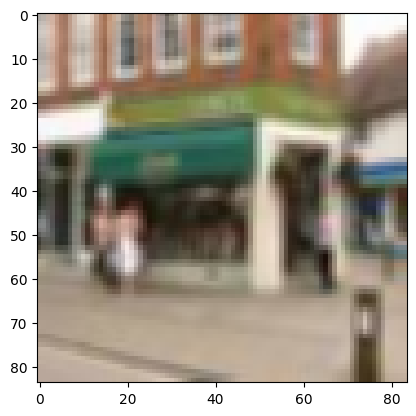

In [15]:
plt.imshow(kornia.augmentation.RandomBoxBlur(p=1.)(not_aug_inputs)[0].transpose(0, 2).transpose(0, 1).numpy())
plt.show()
inputs = not_aug_inputs

In [5]:
partition_func = create_nearest_buffer_instance_func(inputs)

In [6]:
partition = partition_func(inputs)
print(partition)

tensor([   0,    1,    2,  ..., 4997, 4998, 4999])


In [13]:
# transforming
transformation_list = [
    # brightness
    # lambda inp: kornia.morphology.dilation(inp, kernel=torch.ones(3, 3)),
    # lambda inp: kornia.morphology.erosion(inp, kernel=torch.ones(3, 3)),
    # lambda inp: kornia.morphology.opening(inp, kernel=torch.ones(3, 3)),
    # lambda inp: kornia.morphology.closing(inp, kernel=torch.ones(3, 3)),
    # kornia.augmentation.RandomPlanckianJitter(mode='blackbody', p=1., select_from=list(range(24))),
    # kornia.augmentation.RandomPlanckianJitter(mode='CIED', p=1., select_from=list(range(22))),
    # kornia.augmentation.RandomPlasmaShadow(p=1.),
    kornia.augmentation.RandomPlasmaBrightness(p=1.),
    # kornia.augmentation.RandomPlasmaContrast(p=1.),
    # kornia.augmentation.ColorJiggle(p=1.),
    # kornia.augmentation.ColorJitter(p=1.),
    # kornia.augmentation.RandomBoxBlur(p=1.),
    # kornia.augmentation.RandomBrightness(p=1.),
    # kornia.augmentation.RandomChannelShuffle(p=1.),
    # kornia.augmentation.RandomContrast(p=1.),
    # kornia.augmentation.RandomEqualize(p=1.),
    # kornia.augmentation.RandomGamma(p=1.),
    # kornia.augmentation.RandomGrayscale(p=1.),
    # kornia.augmentation.RandomGaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0), p=1.),
    # kornia.augmentation.RandomGaussianNoise(p=1.),
    # kornia.augmentation.RandomHue(p=1.),
    # kornia.augmentation.RandomMotionBlur(p=1., kernel_size=(3, 3), angle=(0, 360), direction=0.5),
    # kornia.augmentation.RandomPosterize(p=1.),
    # kornia.augmentation.RandomRGBShift(p=1.),
    # kornia.augmentation.RandomSaturation(p=1.),
    # kornia.augmentation.RandomSharpness(p=1.),
    # kornia.augmentation.RandomSolarize(p=1.),
    # kornia.augmentation.RandomMedianBlur(p=1.),
    # kornia.augmentation.RandomSnow(p=1.),
    # kornia.augmentation.RandomRain(p=1.),
    # kornia.augmentation.RandomAffine(p=1., degrees=15.0),
    # kornia.augmentation.RandomErasing(p=1.),
    # kornia.augmentation.RandomElasticTransform(p=1.),
    # kornia.augmentation.RandomFisheye(p=1., center_x=torch.Tensor([-3, 3]), center_y=torch.Tensor([-3, 3]), gamma=torch.tensor([.9, 1.])),
    # kornia.augmentation.RandomHorizontalFlip(p=1.),
    # kornia.augmentation.RandomInvert(p=1.),
    # kornia.augmentation.RandomPerspective(p=1.),
    # kornia.augmentation.RandomResizedCrop(p=1., size=(84, 84)),
    # kornia.augmentation.RandomRotation(p=1., degrees=15.0),
    # kornia.augmentation.RandomVerticalFlip(p=1.),
]

In [14]:
same_percentage = []
n_run = 5
for i, transformation in enumerate(transformation_list):
    try:
        # print(i, transformation)
        total_same = 0
        for _ in range(n_run):
            transformed_img = transformation(inputs)
            new_partition = partition_func(transformed_img)
            total_same += (new_partition == partition).sum() / len(new_partition)
        same_percentage.append(total_same / n_run)
        print(f"{i} : {same_percentage[-1]} : {transformation}")
    except:
        same_percentage.append(0)
        print(f"{i} : {same_percentage[-1]} : {transformation}")
# for i, (transformation, same_per) in enumerate(zip(transformation_list, same_percentage)):
#     print(f"{i} : {same_per} : {transformation}")

0 : 0 : RandomPlasmaBrightness(roughness=(0.1, 0.7), intensity=(0.0, 1.0), p=1.0, p_batch=1.0, same_on_batch=False)


In [ ]:
# same_percentage = []
# n_run = 5
# for i, transformation in enumerate(transformation_list):
#     # print(i, transformation)
#     total_same = 0
#     for _ in range(n_run):
#         transformed_img = transformation(inputs)
#         new_partition = partition_func(transformed_img)
#         total_same += (new_partition == partition).sum() / len(new_partition)
#     same_percentage.append(total_same / n_run)
#     print(f"{i} : {same_percentage[-1]} : {transformation}")
# # for i, (transformation, same_per) in enumerate(zip(transformation_list, same_percentage)):
# #     print(f"{i} : {same_per} : {transformation}")

In [ ]:
partition_func(transformed_img)

tensor([3812, 2704, 1560,  ..., 4997, 4998, 1560])

# Description of augmentations
| %same | Name | Description |
|-------|------|-------------|
|0.983199954032898|lambda inp: kornia.morphology.dilation(inp, kernel=torch.ones(3, 3))|x|
|0.954800009727478|lambda inp: kornia.morphology.erosion(inp, kernel=torch.ones(3, 3))|x|
|0.9996000528335571|lambda inp: kornia.morphology.opening(inp, kernel=torch.ones(3, 3))|x|
|0.9998000264167786|lambda inp: kornia.morphology.closing(inp, kernel=torch.ones(3, 3))|x|
|0.951200008392334|RandomPlanckianJitter(PlanckianJitterGenerator(), p=1.0, p_batch=1.0, same_on_batch=False)|x|
|0.9937599301338196|RandomPlanckianJitter(PlanckianJitterGenerator(), p=1.0, p_batch=1.0, same_on_batch=False)|x|
|0.5555599927902222|RandomPlasmaShadow(roughness=(0.1, 0.7), shade_intensity=(-1.0, 0.0), shade_quantity=(0.0, 1.0), p=1.0, p_batch=1.0, same_on_batch=False)|x|
|0.9312399625778198|RandomPlasmaBrightness(roughness=(0.1, 0.7), intensity=(0.0, 1.0), p=1.0, p_batch=1.0, same_on_batch=False)|x|
|0.9972000122070312|RandomPlasmaContrast(roughness=(0.1, 0.7), p=1.0, p_batch=1.0, same_on_batch=False)|x|
|1.0|ColorJiggle(brightness=0.0, contrast=0.0, saturation=0.0, hue=0.0, p=1.0, p_batch=1.0, same_on_batch=False)|x|
|1.0|ColorJitter(brightness=0.0, contrast=0.0, saturation=0.0, hue=0.0, p=1.0, p_batch=1.0, same_on_batch=False)|x|
|1.0|RandomBoxBlur(p=1.0, p_batch=1.0, same_on_batch=False, kernel_size=(3, 3), border_type=reflect, normalized=True)|x|
|1.0|RandomBrightness(brightness_factor=tensor([1., 1.]), p=1.0, p_batch=1.0, same_on_batch=False)|x|
|0.9376400113105774|RandomChannelShuffle(p=1.0, p_batch=1.0, same_on_batch=False)|x|
|1.0|RandomContrast(contrast_factor=tensor([1., 1.]), p=1.0, p_batch=1.0, same_on_batch=False)|x|
|0.863599956035614|RandomEqualize(p=1.0, p_batch=1.0, same_on_batch=False)|x|
|1.0|RandomGamma(gamma_factor=(1.0, 1.0), gain_factor=(1.0, 1.0), p=1.0, p_batch=1.0, same_on_batch=False)|x|
|0.9701999425888062|RandomGrayscale(p=1.0, p_batch=1.0, same_on_batch=False)|x|
|1.0|RandomGaussianBlur(sigma=(0.1, 2.0), p=1.0, p_batch=1.0, same_on_batch=False, kernel_size=(3, 3), separable=True, border_type=reflect)|x|
|1.0|RandomGaussianNoise(p=1.0, p_batch=1.0, same_on_batch=False, mean=0.0, std=1.0)|x|
|1.0|RandomHue(hue_factor=tensor([0., 0.]), p=1.0, p_batch=1.0, same_on_batch=False)|x|
|1.0|RandomMotionBlur(kernel_size=(3, 3), angle=(0, 360), direction=0.5, p=1.0, p_batch=1.0, same_on_batch=False, border_type=constant, resample=nearest)|x|
|1.0|RandomPosterize(bits=3, p=1.0, p_batch=1.0, same_on_batch=False)|x|
|0.46356001496315|RandomRGBShift(r_shift=0.5, g_shift=0.5, b_shift=0.5, p=1.0, p_batch=1.0, same_on_batch=False)|x|
|1.0|RandomSaturation(saturation_factor=tensor([1., 1.]), p=1.0, p_batch=1.0, same_on_batch=False)|x|
|1.0|RandomSharpness(sharpness=0.5, p=1.0, p_batch=1.0, same_on_batch=False)|x|
|0.11779999732971191|RandomSolarize(thresholds=0.1, additions=0.1, p=1.0, p_batch=1.0, same_on_batch=False)|x|
|1.0|RandomMedianBlur(p=1.0, p_batch=1.0, same_on_batch=False, kernel_size=(3, 3))|x|
|0.5054000020027161|RandomSnow(snow_coefficient=(0.5, 0.5), brightness=(2, 2), p=1.0, p_batch=1.0, same_on_batch=False)|x|
|0.002839999971911311|RandomRain(number_of_drops=(1000, 2000), drop_height=(5, 20), drop_width=(-5, 5), p=1.0, p_batch=1.0, same_on_batch=False)|x|
|0.7680799961090088|RandomAffine(degrees=15.0, translate=None, scale=None, shear=None, p=1.0, p_batch=1.0, same_on_batch=False, resample=bilinear, padding_mode=zeros, align_corners=False)|x|
|0.7317999601364136|RandomErasing(scale=(0.02, 0.33), resize_to=(0.3, 3.3), value=0.0, p=1.0, p_batch=1.0, same_on_batch=False)|x|
|1.0|RandomElasticTransform(p=1.0, p_batch=1.0, same_on_batch=False, kernel_size=(63, 63), sigma=(32.0, 32.0), alpha=(1.0, 1.0), align_corners=False, resample=bilinear, padding_mode=zeros)|x|
|0.0001999999803956598|RandomFisheye(center_x=tensor([[-3.], [ 3.]]), center_y=tensor([[-3.],[ 3.]]), gamma=tensor([[0.9000],[1.0000]]), p=1.0, p_batch=1.0, same_on_batch=False)|x|
|0.21279999613761902|RandomHorizontalFlip(p=1.0, p_batch=1.0, same_on_batch=False)|x|
|0.0|RandomInvert(p=1.0, p_batch=1.0, same_on_batch=False, max_val=1.0)|x|
|0.0038800002075731754|RandomPerspective(distortion_scale=0.5, p=1.0, p_batch=1.0, same_on_batch=False, align_corners=False, resample=bilinear)|x|
|0.23747999966144562|RandomResizedCrop(scale=(0.08, 1.0), resize_to=(0.75, 1.3333333333333333), output_size=(84, 84), p=1.0, p_batch=1.0, same_on_batch=False, size=(84, 84), resample=bilinear, align_corners=True, cropping_mode=slice, padding_mode=zeros)|x|
|0.7699199914932251|RandomRotation(degrees=15.0, p=1.0, p_batch=1.0, same_on_batch=False, resample=bilinear, align_corners=True)|x|
|0.07079999893903732|RandomVerticalFlip(p=1.0, p_batch=1.0, same_on_batch=False)|x|

